# THE SPARKS FOUNDATION

# Ridima Tambde

# Task 7- Stock Market Prediction using Numerical and Textual Analysis

Objective: Create a hybrid model for stock price/performance
prediction using numerical analysis of historical stock prices, and
sentimental analysis of news headlines

In [1]:
import warnings 
warnings.filterwarnings('ignore')

# Importing all the required libraries

In [2]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

# Importing SENSEX (S&P BSE SENSEX) dataset and news headline dataset

In [3]:
stock_price=pd.read_csv('^BSESN.csv')
stock_headlines=pd.read_csv('india-news-headlines.csv')

# Displaying 1st five records for SENSEX

In [4]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


# Displaying 1st five records for News Headline

In [5]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [6]:
len(stock_price), len(stock_headlines)

(252, 3424067)

In [7]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

# Data Preprocessing and Exploratory Data Analysis

In [8]:
stock_price=stock_price.drop_duplicates()
stock_price['Date']=pd.to_datetime(stock_price['Date']).dt.normalize()
stock_price=stock_price.filter(['Date','Close','Open','High','Low','Volume'])
stock_price.set_index('Date', inplace=True)
stock_price=stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0
...,...,...,...,...,...
2020-12-11,46099.011719,46060.320313,46309.628906,45706.218750,26300.0
2020-12-14,46253.460938,46284.699219,46373.339844,45951.531250,18400.0
2020-12-15,46263.171875,46287.390625,46350.300781,45841.671875,16400.0


In [9]:
stock_headlines=stock_headlines.drop_duplicates()

stock_headlines['publish_date']=stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date']=stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date']=pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

stock_headlines=stock_headlines.filter(['publish_date','headline_text'])

stock_headlines=stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

stock_headlines.set_index('publish_date', inplace=True)
stock_headlines=stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [10]:
stock_data=pd.concat([stock_price,stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)
stock_data

,Close,Open,High,Low,Volume,headline_text
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...
...,...,...,...,...,...,...
2020-12-11,46099.011719,46060.320313,46309.628906,45706.218750,26300.0,Ways to get you in the mood for sex when you'r...
2020-12-14,46253.460938,46284.699219,46373.339844,45951.531250,18400.0,"No threat from Covid claims to balance sheets,..."
2020-12-15,46263.171875,46287.390625,46350.300781,45841.671875,16400.0,1;147 RT-PCR tests in a day; only 3 found +ve ...
2020-12-16,46666.460938,46573.308594,46704.968750,46402.199219,13100.0,Asmita Sood's favourite holiday destinations a...


In [11]:
stock_data['compound']=''
stock_data['negative']=''
stock_data['neutral']=''
stock_data['positive']=''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...,,,,
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...,,,,
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...,,,,
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...,,,,
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...,,,,


In [12]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sid=SentimentIntensityAnalyzer()

stock_data['compound']=stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative']=stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral']=stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive']=stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

stock_data.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...,-1.0000,0.178,0.748,0.074
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...,-0.9999,0.146,0.782,0.072
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...,-0.9997,0.110,0.833,0.057
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...,-0.9999,0.157,0.769,0.074
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...,-0.9997,0.131,0.788,0.081


In [13]:
stock_data.drop(['headline_text'], axis=1, inplace=True)

stock_data=stock_data[['Close','compound','negative','neutral','positive','Open','High','Low','Volume']]

stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2019-12-17,41352.171875,-1.0000,0.178,0.748,0.074,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,-0.9999,0.146,0.782,0.072,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,-0.9997,0.110,0.833,0.057,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,-0.9999,0.157,0.769,0.074,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,-0.9997,0.131,0.788,0.081,41548.261719,41701.621094,41474.609375,6200.0


# Importing Apple stocks dataset

In [14]:
stock_data.to_csv('AAPL.csv')

In [16]:
stock_data=pd.read_csv('AAPL.csv',index_col=False)
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
stock_data.set_index('Date', inplace=True)
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2019-12-17,41352.171875,-1.0000,0.178,0.748,0.074,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,-0.9999,0.146,0.782,0.072,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,-0.9997,0.110,0.833,0.057,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,-0.9999,0.157,0.769,0.074,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,-0.9997,0.131,0.788,0.081,41548.261719,41701.621094,41474.609375,6200.0


In [17]:
stock_data.shape

(250, 9)

In [18]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [19]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37745.454117,-0.991426,0.128724,0.794076,0.077160,37804.237375,38071.182859,37422.826992,19134.000000
std,4535.304336,0.126305,0.020739,0.025585,0.012089,4507.985769,4380.974060,4647.212947,16540.261333
min,25981.240234,-1.000000,0.076000,0.728000,0.046000,26499.810547,27462.869141,25638.900391,0.000000
25%,34257.097656,-0.999900,0.115000,0.776000,0.069000,34369.659179,34779.932618,33975.389648,13125.000000
50%,38425.974610,-0.999750,0.128000,0.791000,0.077000,38489.480469,38750.359375,38234.869140,17000.000000
75%,41135.233399,-0.999500,0.141000,0.812000,0.085000,41179.222656,41376.482422,41023.923828,21075.000000
max,46890.339844,0.997400,0.199000,0.867000,0.127000,46774.320313,46992.570313,46627.601563,188300.000000


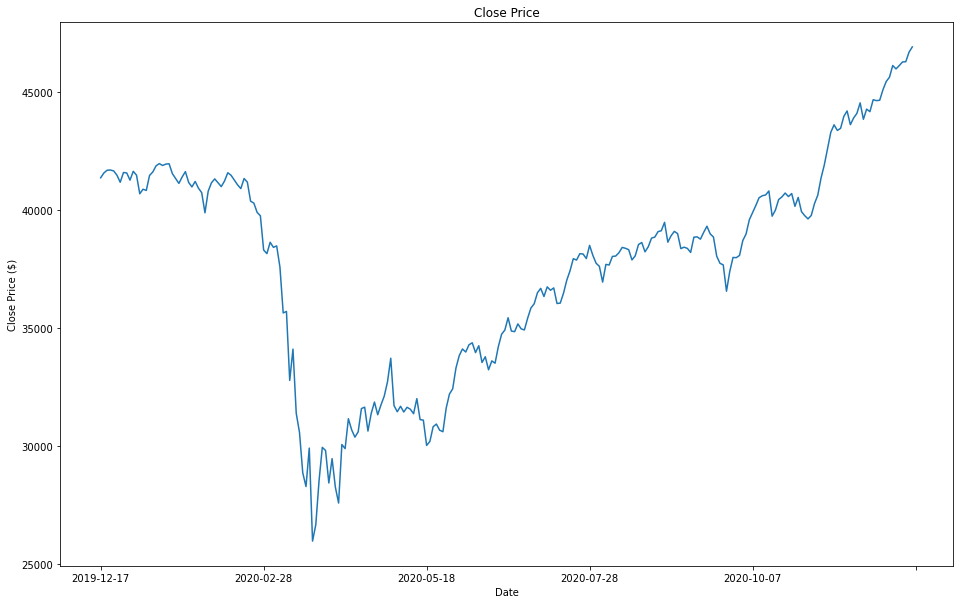

In [20]:
plt.figure(figsize=(16,10))
stock_data['Close'].plot()

plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

In [21]:
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2019-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,41504.840960,-0.999857,0.144714,0.781143,0.074143,41512.814732,41642.010045,41355.246652,18057.142857
2019-12-27,41536.693639,-0.999843,0.144000,0.782286,0.073714,41547.774554,41671.955915,41392.352679,16214.285714
2019-12-30,41536.612165,-0.999843,0.147429,0.778429,0.074286,41582.563058,41686.236049,41405.911272,13557.142857


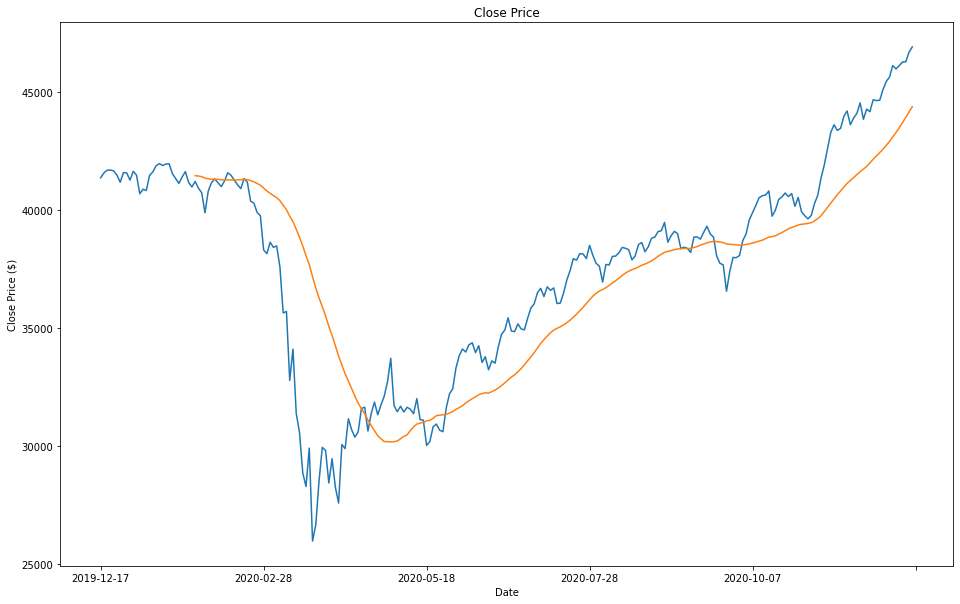

In [22]:
plt.figure(figsize=(16,10))

stock_data['Close'].plot()
stock_data.rolling(30).mean()['Close'].plot()
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()